In [1]:
import torch
import numpy as np
import glob
import os

from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import (
    AsDiscrete,
    Activations,
    Compose,
    LoadImaged,
    ConvertToMultiChannelBasedOnBratsClassesd,
    CropForegroundd,
    RandSpatialCropd,
    RandFlipd,
    NormalizeIntensityd,
    RandShiftIntensityd,
    RandScaleIntensityd,
    Lambdad,
    EnsureChannelFirstd,
    ToTensord,
    Transform
)
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai.losses import DiceLoss, DiceCELoss
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
from functools import partial

from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
#dataset_list = []

# read all folders in Images

base_path = "Task01_BrainTumour/"

train_images = sorted(glob.glob(os.path.join(base_path, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(base_path, "labelsTr", "*.nii.gz")))

dataset_list = [
    {"img": image_name, "seg": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

"""
for file in os.listdir(os.path.join(base_path, "imagesTr")):

    data_dict = {
        "img": os.path.join(base_path, "imagesTr", file), 
        "seg": os.path.join(base_path, "labelsTr", file)
    }
    dataset_list.append(data_dict)"""

train_dataset_list, val_dataset_list = dataset_list[:-94], dataset_list[-94:]

# only use 70 percent of the total data
#train_dataset_list, val_dataset_list = train_dataset_list[:int(len(train_dataset_list)*0.7)], val_dataset_list[:int(len(val_dataset_list)*0.7)]

print(len(train_dataset_list), len(val_dataset_list))

390 94


In [4]:
"""from monai.transforms import (
    Compose,
    LoadImage,
    ConvertToMultiChannelBasedOnBratsClasses,
    CropForeground,
    RandSpatialCrop,
    RandFlip,
    NormalizeIntensity,
    RandShiftIntensity,
    RandScaleIntensity,
    EnsureChannelFirst,
    Lambda
)


img = LoadImage(image_only=True)(train_dataset_list[0]["img"])
print(img.shape)

img = EnsureChannelFirst()(train_dataset_list[0])
print(img.shape)

img = EnsureChannelFirst()(img)
print(img.shape)

img = Lambda(lambda x: x.permute(3,2,0,1))(img)
print(img.shape)

img = CropForeground()(img)
print(img.shape)

img = RandSpatialCrop((128, 128, 128), random_size=False)(img)
print(img.shape)

img = RandFlip(prob=0.5, spatial_axis=0)(img)
print(img.shape)

img = NormalizeIntensity(nonzero=True, channel_wise=True)(img)
print(img.shape)

img = RandShiftIntensity(offsets=0.1, prob=1.0)(img)
print(img.shape)

img = RandScaleIntensity(prob=0.5, factors=0.1)(img)
print(img.shape)
"""

'from monai.transforms import (\n    Compose,\n    LoadImage,\n    ConvertToMultiChannelBasedOnBratsClasses,\n    CropForeground,\n    RandSpatialCrop,\n    RandFlip,\n    NormalizeIntensity,\n    RandShiftIntensity,\n    RandScaleIntensity,\n    EnsureChannelFirst,\n    Lambda\n)\n\n\nimg = LoadImage(image_only=True)(train_dataset_list[0]["img"])\nprint(img.shape)\n\nimg = EnsureChannelFirst()(train_dataset_list[0])\nprint(img.shape)\n\nimg = EnsureChannelFirst()(img)\nprint(img.shape)\n\nimg = Lambda(lambda x: x.permute(3,2,0,1))(img)\nprint(img.shape)\n\nimg = CropForeground()(img)\nprint(img.shape)\n\nimg = RandSpatialCrop((128, 128, 128), random_size=False)(img)\nprint(img.shape)\n\nimg = RandFlip(prob=0.5, spatial_axis=0)(img)\nprint(img.shape)\n\nimg = NormalizeIntensity(nonzero=True, channel_wise=True)(img)\nprint(img.shape)\n\nimg = RandShiftIntensity(offsets=0.1, prob=1.0)(img)\nprint(img.shape)\n\nimg = RandScaleIntensity(prob=0.5, factors=0.1)(img)\nprint(img.shape)\n'

In [5]:
class CustomConvertToMultiChannelBasedOnBratsClasses(Transform):
    """
    Convert labels to multi channels based on brats18 classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).
    """

    backend = ["torch", "numpy"]

    def __call__(self, img):
        # if img has channel dim, squeeze it
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)

        result = [(img == 2) | (img == 3), (img == 2) | (img == 3) | (img == 1), img == 3]
        # merge labels 1 (tumor non-enh) and 4 (tumor enh) and 2 (large edema) to WT
        # label 4 is ET
        return torch.stack(result, dim=0) if isinstance(img, torch.Tensor) else np.stack(result, axis=0)

In [6]:
"""train_transform = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            #ConvertToMultiChannelBasedOnBratsClassesd(keys="seg"),
            #Lambdad(keys=["img", "seg"], func=lambda x: x.permute(3,2,0,1)),
            EnsureChannelFirstd(keys=["img", "seg"]),
            Lambdad(keys=["img", "seg"], func=lambda x: x.permute(0,3,1,2)),
            CropForegroundd(
                keys=["img", "seg"],
                source_key="img",
                #k_divisible=[128, 128, 128],
            ),
            RandSpatialCropd(
                keys=["img", "seg"],
                roi_size=[96, 96, 96],
                random_size=False,
            ),
            RandFlipd(keys=["img", "seg"], prob=0.5, spatial_axis=0),
            RandFlipd(keys=["img", "seg"], prob=0.5, spatial_axis=1),
            RandFlipd(keys=["img", "seg"], prob=0.5, spatial_axis=2),
            NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),
            RandScaleIntensityd(keys="img", factors=0.1, prob=1.0),
            RandShiftIntensityd(keys="img", offsets=0.1, prob=1.0),
        ]
    )

val_transform = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            EnsureChannelFirstd(keys=["img", "seg"]),
            Lambdad(keys=["img", "seg"], func=lambda x: x.permute(0,3,1,2)),
            NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),
        ]
    )"""

instance = CustomConvertToMultiChannelBasedOnBratsClasses()
train_transform = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img"]),
        #Lambdad(keys=["img", "seg"], func=lambda x: x.permute(0, 3, 1, 2)),
        #ConvertToMultiChannelBasedOnBratsClassesd(keys="seg"),
        Lambdad(keys=["seg"], func=lambda x: instance(x)),
        CropForegroundd(keys=["img", "seg"], source_key="img", k_divisible=[96, 96, 96]),
        RandSpatialCropd(keys=["img", "seg"], roi_size=[96, 96, 96], random_size=False),
        RandFlipd(keys=["img", "seg"], prob=0.5, spatial_axis=0),  # Reduce probability
        RandFlipd(keys=["img", "seg"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["img", "seg"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),  # Change to global normalization
        RandScaleIntensityd(keys="img", factors=0.1, prob=1.0),  # Reduce probability and factor
        RandShiftIntensityd(keys="img", offsets=0.1, prob=1.0),  # Reduce probability and offset
        #ToTensord(keys=["img", "seg"]),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img"]),
        Lambdad(keys=["seg"], func=lambda x: instance(x)),
        #ConvertToMultiChannelBasedOnBratsClassesd(keys="seg"),
        #Lambdad(keys=["img", "seg"], func=lambda x: x.permute(0, 3, 1, 2)),
        NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),  # Change to global normalization
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [7]:
img = train_transform(train_dataset_list[0])

print(img["img"].shape, img["seg"].shape)

torch.Size([4, 96, 96, 96]) torch.Size([3, 96, 96, 96])


In [8]:
train_dataset = Dataset(train_dataset_list, transform=train_transform)
val_dataset = Dataset(val_dataset_list, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=os.cpu_count() // 2)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=os.cpu_count() // 2)

In [9]:
model = SwinUNETR(
    in_channels=4,
    out_channels=3,
    img_size=96,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
).to(device)


In [10]:
def calculate_iou(predicted, target):
    """
    Calculate Intersection over Union (IoU) for binary segmentation.

    Args:
    - predicted (torch.Tensor): Predicted binary mask (0 or 1).
    - target (torch.Tensor): Ground truth binary mask (0 or 1).

    Returns:
    - float: IoU score.
    """
    intersection = torch.logical_and(predicted, target).sum().item()
    union = torch.logical_or(predicted, target).sum().item()

    iou = intersection / union if union != 0 else 0.0
    return iou

In [11]:
#loss_function = DiceCELoss(to_onehot_y=True, softmax=True) #torch.nn.MSELoss()
#optimizer = torch.optim.AdamW(model.parameters(), 0.1)

torch.backends.cudnn.benchmark = True
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_accuracy = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[96, 96, 96],
    sw_batch_size=4,
    predictor=model,
    overlap=0.5,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [12]:
class AverageMeter(object):
    def __init__(self):        
        self.reset()
    def reset(self):        
        self.val = 0        
        self.avg = 0        
        self.sum = 0        
        self.count = 0
    def update(self, val, n=1):        
        self.val = val       
        self.sum += val * n        
        self.count += n        
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

In [13]:
num_epochs = 100
val_iteration = 10
losses = []
test_losses = []
ious = []
test_ious = []
dice_accs = []
test_dice_accs = []
best_metric = -1
best_metric_epoch = -1

for epoch in range(num_epochs):

    epoch_loss = 0
    epoch_test_loss = 0
    epoch_iou = 0
    epoch_test_iou = 0
    train_run = AverageMeter()

    model.train()
    epoch_dice_accs = []
    for idx, batch_data in enumerate(tqdm(train_loader)):
        img, seg = batch_data["img"].to(device), batch_data["seg"].to(device)
        dice_accuracy.reset()
        optimizer.zero_grad()
        output = model(img)
        loss = loss_function(output, seg)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_iou += calculate_iou(output, seg)

        try:
            #print(post_pred(post_sigmoid(output)))
            #print(dice_accuracy(y_pred=seg, y=seg))
            dice_accuracy(y_pred=post_pred(post_sigmoid(output)), y=seg)
            acc, not_nans = dice_accuracy.aggregate()
            train_run.update(acc.cpu().numpy(), not_nans.cpu().numpy())

            """if True not in np.isnan(acc.cpu().numpy()):
                dice_accs.append(acc.cpu().numpy())
                epoch_dice_accs.append(acc.cpu().numpy())
            else:
                pass
                """
            #print(acc.cpu().numpy())
            dice_accs.append(acc.cpu().numpy())
        except Exception as e:
            print(e)
            acc = dice_accuracy(y_pred=post_pred(post_sigmoid(output)), y=seg)
            #print(acc)
            #dice_accs.append([acc.cpu().numpy()])
        
        iou = calculate_iou(output, seg)
        ious.append(iou)

    test_epoch_dice_accs = []
    if (epoch + 1) % val_iteration == 0:
        model.eval()
        val_run = AverageMeter()
        with torch.no_grad():
            
            
            for idx, batch_data in enumerate(val_loader):
                img, seg = batch_data["img"].to(device), batch_data["seg"].to(device)
                output = model_inferer(img)
                val_labels_list = decollate_batch(seg)
                val_outputs_list = decollate_batch(output)
                val_output_convert = [post_pred(post_sigmoid(el)) for el in val_outputs_list]
                dice_accuracy.reset()
                dice_accuracy(y_pred=val_output_convert, y=val_labels_list)
                acc, not_nans = dice_accuracy.aggregate()
                val_run.update(acc.cpu().numpy(), not_nans.cpu().numpy())
                if True not in np.isnan(acc.cpu().numpy()):
                    test_dice_accs.append(acc.cpu().numpy())
                    test_epoch_dice_accs.append(acc.cpu().numpy())

                loss = loss_function(output, seg)
                test_losses.append(loss.item())
                epoch_test_loss += loss.item()

                iou = calculate_iou(output, seg)
                test_ious.append(iou)

                epoch_test_iou += calculate_iou(output, seg)

        
        if np.average(test_epoch_dice_accs) > best_metric:
            best_metric = np.average(test_epoch_dice_accs)
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_brain_metric_model.pth")
            print("saved new best brain metric model")
        
        print(f"""
                Epoch: {epoch} / {num_epochs} 
                | Train Loss: {epoch_loss / len(train_loader)} 
                | Test Loss: {epoch_test_loss / len(val_loader)} 
                | Train IoU: {ious[-1]} 
                | Test IoU: {test_ious[-1]}
                | Train Dice Accuracy: {train_run.avg} 
                | Test Dice Accuracy: {val_run.avg}
            """)
        
    else:
        print(f"""
                Epoch: {epoch} / {num_epochs} 
                | Train Loss: {epoch_loss / len(train_loader)} 
                | Train Dice Accuracy: {train_run.avg} 
            """)
            

    scheduler.step()
        


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 0 / 100 
                | Train Loss: 0.8674495418866476 
                | Train Dice Accuracy: [0.27500135 0.4949962  0.0629358 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 1 / 100 
                | Train Loss: 0.8182934745764121 
                | Train Dice Accuracy: [0.3729773  0.61418474 0.14892237] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 2 / 100 
                | Train Loss: 0.7670990567940932 
                | Train Dice Accuracy: [0.46541777 0.65851325 0.29328907] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 3 / 100 
                | Train Loss: 0.7194957285355299 
                | Train Dice Accuracy: [0.50392526 0.6786337  0.36335   ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 4 / 100 
                | Train Loss: 0.6619895442938193 
                | Train Dice Accuracy: [0.55420023 0.7110208  0.48237014] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 5 / 100 
                | Train Loss: 0.604756571772771 
                | Train Dice Accuracy: [0.5803217  0.72124386 0.57148296] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 6 / 100 
                | Train Loss: 0.5729321638743082 
                | Train Dice Accuracy: [0.6071932 0.7189845 0.6163491] 
            


  0%|          | 0/195 [00:00<?, ?it/s]

invalid value encountered in divide



                Epoch: 7 / 100 
                | Train Loss: 0.534799169195004 
                | Train Dice Accuracy: [0.61599547 0.7474158  0.63893807] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 8 / 100 
                | Train Loss: 0.5043420003774839 
                | Train Dice Accuracy: [0.6204962  0.73642266 0.64125794] 
            


  0%|          | 0/195 [00:00<?, ?it/s]

saved new best brain metric model

                Epoch: 9 / 100 
                | Train Loss: 0.4775411605070799 
                | Test Loss: 0.3541565699146149 
                | Train IoU: 0.019578533408082563 
                | Test IoU: 0.00559375
                | Train Dice Accuracy: [0.6395078 0.7641216 0.6644523] 
                | Test Dice Accuracy: [0.8001814  0.8906426  0.82196105]
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 10 / 100 
                | Train Loss: 0.48521194557348885 
                | Train Dice Accuracy: [0.6697889  0.73845977 0.68944335] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 11 / 100 
                | Train Loss: 0.4640836609097628 
                | Train Dice Accuracy: [0.6591365 0.7584879 0.6652642] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 12 / 100 
                | Train Loss: 0.4709802542359401 
                | Train Dice Accuracy: [0.6581221  0.7327752  0.69585574] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 13 / 100 
                | Train Loss: 0.4205756564552967 
                | Train Dice Accuracy: [0.683259   0.7628603  0.71143466] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 14 / 100 
                | Train Loss: 0.4203391772432205 
                | Train Dice Accuracy: [0.6812329  0.78649294 0.69124955] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 15 / 100 
                | Train Loss: 0.4276972659887412 
                | Train Dice Accuracy: [0.6724179 0.7743225 0.6918212] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 16 / 100 
                | Train Loss: 0.4190514284448746 
                | Train Dice Accuracy: [0.68671787 0.777441   0.71860147] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 17 / 100 
                | Train Loss: 0.42004596686516055 
                | Train Dice Accuracy: [0.6816622  0.7753429  0.70982033] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 18 / 100 
                | Train Loss: 0.4218019942442576 
                | Train Dice Accuracy: [0.66257125 0.7806901  0.66389656] 
            


  0%|          | 0/195 [00:00<?, ?it/s]

saved new best brain metric model

                Epoch: 19 / 100 
                | Train Loss: 0.4110206127548829 
                | Test Loss: 0.20540338516869444 
                | Train IoU: 0.003789454330632716 
                | Test IoU: 0.00559375
                | Train Dice Accuracy: [0.6858669  0.79329425 0.7046753 ] 
                | Test Dice Accuracy: [0.8089048  0.88598096 0.82437694]
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 20 / 100 
                | Train Loss: 0.4410564749668806 
                | Train Dice Accuracy: [0.6736262  0.76409554 0.69839156] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 21 / 100 
                | Train Loss: 0.41593756263072673 
                | Train Dice Accuracy: [0.69116604 0.7663784  0.71387714] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 22 / 100 
                | Train Loss: 0.4273030184018306 
                | Train Dice Accuracy: [0.67223305 0.7653245  0.7020125 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 23 / 100 
                | Train Loss: 0.4047050356482848 
                | Train Dice Accuracy: [0.69089377 0.7830782  0.7114185 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 24 / 100 
                | Train Loss: 0.40238513128879744 
                | Train Dice Accuracy: [0.6846076  0.797146   0.69344217] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 25 / 100 
                | Train Loss: 0.38805559006256934 
                | Train Dice Accuracy: [0.69102424 0.7950952  0.7014105 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 26 / 100 
                | Train Loss: 0.4042721211528167 
                | Train Dice Accuracy: [0.6980261  0.78597397 0.7175112 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 27 / 100 
                | Train Loss: 0.41376444399356843 
                | Train Dice Accuracy: [0.67854476 0.7778618  0.6776186 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 28 / 100 
                | Train Loss: 0.3960332841063157 
                | Train Dice Accuracy: [0.6980087  0.7758073  0.71228355] 
            


  0%|          | 0/195 [00:00<?, ?it/s]

saved new best brain metric model

                Epoch: 29 / 100 
                | Train Loss: 0.4079942567226214 
                | Test Loss: 0.15899209646468468 
                | Train IoU: 0.01509715892650463 
                | Test IoU: 0.00559375
                | Train Dice Accuracy: [0.6929772 0.7948852 0.7119642] 
                | Test Dice Accuracy: [0.8405997  0.90080535 0.8346551 ]
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 30 / 100 
                | Train Loss: 0.4238616639987016 
                | Train Dice Accuracy: [0.6934778  0.78629476 0.71149313] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 31 / 100 
                | Train Loss: 0.39734365810186434 
                | Train Dice Accuracy: [0.6943854  0.78829956 0.724702  ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 32 / 100 
                | Train Loss: 0.38189289378814206 
                | Train Dice Accuracy: [0.72849554 0.79324526 0.71534157] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 33 / 100 
                | Train Loss: 0.39872039472445464 
                | Train Dice Accuracy: [0.69940776 0.79438394 0.6976473 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 34 / 100 
                | Train Loss: 0.394196304335044 
                | Train Dice Accuracy: [0.70674044 0.79431486 0.70903945] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 35 / 100 
                | Train Loss: 0.3835543411282393 
                | Train Dice Accuracy: [0.7105648 0.8034947 0.7060474] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 36 / 100 
                | Train Loss: 0.3796369454417473 
                | Train Dice Accuracy: [0.7144073  0.80390036 0.7400448 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 37 / 100 
                | Train Loss: 0.38681295120563264 
                | Train Dice Accuracy: [0.7203093  0.79143554 0.7117542 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 38 / 100 
                | Train Loss: 0.410640574972599 
                | Train Dice Accuracy: [0.69134855 0.7900583  0.7125705 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 39 / 100 
                | Train Loss: 0.3898148751602723 
                | Test Loss: 0.15642521530389786 
                | Train IoU: 0.032217708634741514 
                | Test IoU: 0.00559375
                | Train Dice Accuracy: [0.72359943 0.7931094  0.71870154] 
                | Test Dice Accuracy: [0.81835264 0.9052275  0.8391118 ]
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 40 / 100 
                | Train Loss: 0.3686985358595848 
                | Train Dice Accuracy: [0.71470976 0.80217564 0.72960645] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 41 / 100 
                | Train Loss: 0.3929494773157132 
                | Train Dice Accuracy: [0.71450204 0.7790599  0.74667126] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 42 / 100 
                | Train Loss: 0.41179138634067314 
                | Train Dice Accuracy: [0.6943713 0.7875059 0.7087361] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 43 / 100 
                | Train Loss: 0.38155549955673707 
                | Train Dice Accuracy: [0.7181765  0.80651414 0.72451234] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 44 / 100 
                | Train Loss: 0.39675785448306644 
                | Train Dice Accuracy: [0.6982917 0.7755384 0.710733 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 45 / 100 
                | Train Loss: 0.3861484438563004 
                | Train Dice Accuracy: [0.69295084 0.7961535  0.71966916] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 46 / 100 
                | Train Loss: 0.38785862651390907 
                | Train Dice Accuracy: [0.6982434 0.7926199 0.7031916] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 47 / 100 
                | Train Loss: 0.36226088461967615 
                | Train Dice Accuracy: [0.710051   0.80325687 0.7218521 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 48 / 100 
                | Train Loss: 0.35966834206229603 
                | Train Dice Accuracy: [0.73543704 0.81522846 0.7313333 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]

saved new best brain metric model

                Epoch: 49 / 100 
                | Train Loss: 0.3861635654209516 
                | Test Loss: 0.1443414288632413 
                | Train IoU: 0.006641340844425155 
                | Test IoU: 0.00559375
                | Train Dice Accuracy: [0.73768157 0.79440403 0.7298783 ] 
                | Test Dice Accuracy: [0.84541076 0.9036392  0.8398193 ]
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 50 / 100 
                | Train Loss: 0.3865914916189817 
                | Train Dice Accuracy: [0.70091707 0.79380137 0.7238737 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 51 / 100 
                | Train Loss: 0.36395426587416574 
                | Train Dice Accuracy: [0.73491144 0.79999584 0.7287082 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 52 / 100 
                | Train Loss: 0.35336828340704624 
                | Train Dice Accuracy: [0.7440885 0.8181353 0.7421009] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 53 / 100 
                | Train Loss: 0.38748293849520193 
                | Train Dice Accuracy: [0.7169541 0.8053778 0.7184178] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 54 / 100 
                | Train Loss: 0.3866232601877971 
                | Train Dice Accuracy: [0.71550715 0.8063559  0.7212284 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 55 / 100 
                | Train Loss: 0.36186073527504237 
                | Train Dice Accuracy: [0.71616805 0.816776   0.72675586] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 56 / 100 
                | Train Loss: 0.39183959785180217 
                | Train Dice Accuracy: [0.706129   0.80560195 0.7163042 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 57 / 100 
                | Train Loss: 0.36179341393021436 
                | Train Dice Accuracy: [0.7183276 0.8236526 0.7263635] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 58 / 100 
                | Train Loss: 0.38140409619380267 
                | Train Dice Accuracy: [0.7136564  0.7996125  0.73296505] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 59 / 100 
                | Train Loss: 0.3830877403036142 
                | Test Loss: 0.14840479797505318 
                | Train IoU: 0.006691449954185957 
                | Test IoU: 0.00559375
                | Train Dice Accuracy: [0.6995017  0.79579204 0.71356386] 
                | Test Dice Accuracy: [0.8318297  0.89999473 0.8418224 ]
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 60 / 100 
                | Train Loss: 0.36633733209127034 
                | Train Dice Accuracy: [0.72440886 0.8233873  0.7372413 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 61 / 100 
                | Train Loss: 0.3845033775919523 
                | Train Dice Accuracy: [0.68870944 0.7981302  0.715583  ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 62 / 100 
                | Train Loss: 0.3927010466464055 
                | Train Dice Accuracy: [0.7171256  0.7960746  0.74161386] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 63 / 100 
                | Train Loss: 0.38031042577364504 
                | Train Dice Accuracy: [0.718021   0.7926353  0.73235846] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 64 / 100 
                | Train Loss: 0.35598184963067375 
                | Train Dice Accuracy: [0.71965194 0.8076179  0.73434097] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 65 / 100 
                | Train Loss: 0.36795868109434077 
                | Train Dice Accuracy: [0.73969144 0.81908864 0.7437595 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 66 / 100 
                | Train Loss: 0.35421512262561383 
                | Train Dice Accuracy: [0.73980975 0.819782   0.72822237] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 67 / 100 
                | Train Loss: 0.3622793241571157 
                | Train Dice Accuracy: [0.7363252  0.80588245 0.73303944] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 68 / 100 
                | Train Loss: 0.3678572611931043 
                | Train Dice Accuracy: [0.74362695 0.81343114 0.734169  ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]

saved new best brain metric model

                Epoch: 69 / 100 
                | Train Loss: 0.3860505386422842 
                | Test Loss: 0.1359503004462161 
                | Train IoU: 0.015109026873553241 
                | Test IoU: 0.00559375
                | Train Dice Accuracy: [0.7189951  0.81054765 0.7288075 ] 
                | Test Dice Accuracy: [0.861277  0.9110255 0.8342801]
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 70 / 100 
                | Train Loss: 0.36764733000443534 
                | Train Dice Accuracy: [0.7480556 0.8088131 0.7504547] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 71 / 100 
                | Train Loss: 0.36756315395618094 
                | Train Dice Accuracy: [0.7546283  0.80151284 0.7382215 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 72 / 100 
                | Train Loss: 0.3711800439426532 
                | Train Dice Accuracy: [0.73023385 0.8065463  0.72375673] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 73 / 100 
                | Train Loss: 0.38500073903646226 
                | Train Dice Accuracy: [0.72731256 0.80275476 0.74185145] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 74 / 100 
                | Train Loss: 0.32730361775327954 
                | Train Dice Accuracy: [0.76106167 0.8324755  0.75592715] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 75 / 100 
                | Train Loss: 0.3704345963322199 
                | Train Dice Accuracy: [0.7408147  0.80740684 0.7534096 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 76 / 100 
                | Train Loss: 0.3974001785119375 
                | Train Dice Accuracy: [0.73015726 0.8035421  0.7410948 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 77 / 100 
                | Train Loss: 0.37268916504123273 
                | Train Dice Accuracy: [0.7383137  0.8183418  0.75087214] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 78 / 100 
                | Train Loss: 0.36335620106412814 
                | Train Dice Accuracy: [0.7437233  0.8197586  0.74161965] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 79 / 100 
                | Train Loss: 0.37706306242407894 
                | Test Loss: 0.13667632433328222 
                | Train IoU: 0.039744812765239196 
                | Test IoU: 0.00559375
                | Train Dice Accuracy: [0.7236391 0.817958  0.7302993] 
                | Test Dice Accuracy: [0.85301775 0.910559   0.8399303 ]
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 80 / 100 
                | Train Loss: 0.38208907280976956 
                | Train Dice Accuracy: [0.7326628  0.819086   0.73277557] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 81 / 100 
                | Train Loss: 0.35959852628218825 
                | Train Dice Accuracy: [0.7416384  0.80860245 0.747218  ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 82 / 100 
                | Train Loss: 0.34986290326103187 
                | Train Dice Accuracy: [0.73879474 0.8277541  0.73010147] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 83 / 100 
                | Train Loss: 0.3527071294685205 
                | Train Dice Accuracy: [0.7311164  0.8112675  0.72562516] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 84 / 100 
                | Train Loss: 0.3676987536442585 
                | Train Dice Accuracy: [0.74167013 0.79972386 0.7474823 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 85 / 100 
                | Train Loss: 0.34429511699156884 
                | Train Dice Accuracy: [0.73982006 0.83212864 0.746917  ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 86 / 100 
                | Train Loss: 0.3712784660932345 
                | Train Dice Accuracy: [0.7347853 0.8208235 0.7376563] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 87 / 100 
                | Train Loss: 0.36563568424720033 
                | Train Dice Accuracy: [0.7322682  0.8201172  0.73580873] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 88 / 100 
                | Train Loss: 0.34991498367908674 
                | Train Dice Accuracy: [0.73894054 0.81834555 0.7603243 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 89 / 100 
                | Train Loss: 0.3506870748905035 
                | Test Loss: 0.1368582897046779 
                | Train IoU: 0.021107614776234566 
                | Test IoU: 0.00559375
                | Train Dice Accuracy: [0.73116636 0.82088315 0.7385355 ] 
                | Test Dice Accuracy: [0.85460055 0.9085502  0.83977157]
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 90 / 100 
                | Train Loss: 0.3810061458975841 
                | Train Dice Accuracy: [0.7193601  0.8124447  0.71668476] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 91 / 100 
                | Train Loss: 0.3496759002789473 
                | Train Dice Accuracy: [0.7383007  0.8233558  0.76054424] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 92 / 100 
                | Train Loss: 0.3703617572402343 
                | Train Dice Accuracy: [0.7598028 0.8267957 0.7471522] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 93 / 100 
                | Train Loss: 0.36400176210281177 
                | Train Dice Accuracy: [0.73377323 0.81113964 0.75392157] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 94 / 100 
                | Train Loss: 0.37084974438334123 
                | Train Dice Accuracy: [0.71859074 0.8011651  0.7443893 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 95 / 100 
                | Train Loss: 0.3804203900389182 
                | Train Dice Accuracy: [0.72878516 0.81299347 0.73806   ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 96 / 100 
                | Train Loss: 0.3720985516905785 
                | Train Dice Accuracy: [0.7425622 0.8146892 0.7334932] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 97 / 100 
                | Train Loss: 0.35269774893919625 
                | Train Dice Accuracy: [0.74535066 0.83112884 0.7511136 ] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 98 / 100 
                | Train Loss: 0.3622355830592987 
                | Train Dice Accuracy: [0.7365606 0.8108505 0.7402692] 
            


  0%|          | 0/195 [00:00<?, ?it/s]


                Epoch: 99 / 100 
                | Train Loss: 0.3957454758958939 
                | Test Loss: 0.13814879470366112 
                | Train IoU: 0.015342994972511573 
                | Test IoU: 0.00559375
                | Train Dice Accuracy: [0.75170517 0.8045074  0.7406131 ] 
                | Test Dice Accuracy: [0.8502363 0.9074537 0.8412672]
            


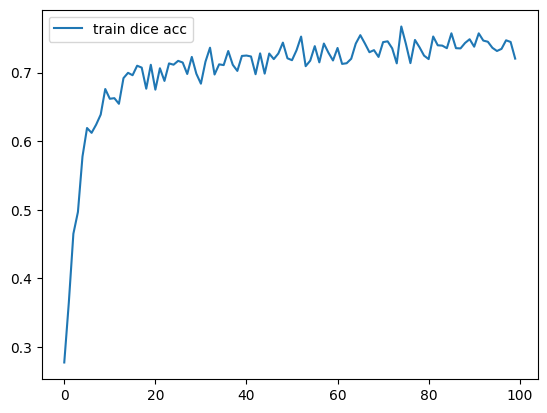

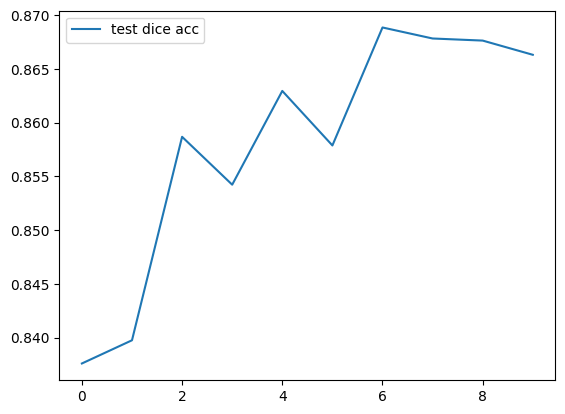

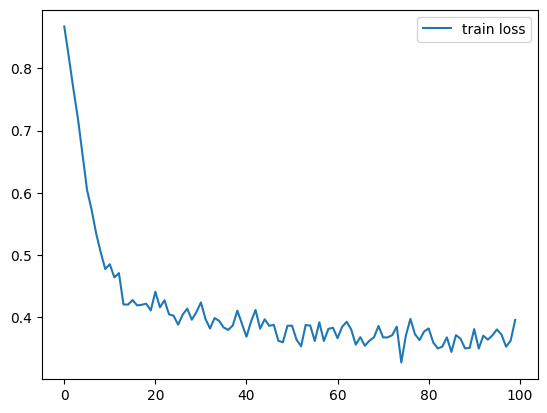

In [21]:

import matplotlib.pyplot as plt

mean_dice_accs = []
mean_test_dice_accs = []
mean_train_loss = []

for i in range(0, len(dice_accs), 195):
    mean_dice_accs.append(np.average(dice_accs[i:i+195]))
    mean_train_loss.append(np.average(losses[i:i+195]))

for i in range(0, len(test_dice_accs), 47):
    mean_test_dice_accs.append(np.average(test_dice_accs[i:i+47]))




plt.plot(mean_dice_accs, label="train dice acc")
plt.legend()
plt.show()

plt.plot(mean_test_dice_accs, label="test dice acc")
plt.legend()
plt.show()

plt.plot(mean_train_loss, label="train loss")
plt.legend()
plt.show()

#
